# Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import stanza
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, f1_score)

import io
from tqdm import tqdm
tqdm.pandas()


## 1. Yelp data

In [2]:
yelp_data = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
yelp_data.columns = ['Review', 'Sentiment']
yelp_data

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


## 2. SentiWords

In [3]:
with open('SentiWords_1.1.txt') as f:
    raw_data = f.readlines()

data = []
    
for line in raw_data:
    # removing license info
    if line[0] != '#':
        data.append(line)
        
senti_words = pd.read_csv(io.StringIO(''.join(data)), sep='#|\t', header=None, engine='python')
senti_words.columns = ['Lemma', 'PoS', 'Prior polarity']

senti_words
    

,Lemma,PoS,Prior polarity
0,.22_caliber,a,0.00000
1,.22_calibre,a,0.00000
2,.22-caliber,a,0.00000
3,.22-calibre,a,0.00000
4,.22,n,0.12208
...,...,...,...
155282,zymolytic,a,-0.19821
155283,zymosis,n,0.15754
155284,zymotic,a,-0.08847
155285,zymurgy,n,0.00000


In [4]:
# PoS tags in SentiWords data
senti_words['PoS'].value_counts()


n    117798
a     21479
v     11529
r      4481
Name: PoS, dtype: int64

## 3. Lexicon-based Sentiment Classification Model

In [5]:
class LexiconSentimentClassifier():

    def __init__(self):

        # Using Stanza for tokenization, lemmatization and PoS-tagging
        self.nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma', download_method='reuse_resources')
        
        # Converting senti_words dataframe into dictionary for efficient search of lemmas
        self.senti_words_dict = senti_words.set_index(['Lemma', 'PoS'])['Prior polarity'].to_dict()
        
        
    def map_pos_tag(self, pos_tag):
        """ Maps a Stanza PoS tag into SentiWords PoS tag """

        if pos_tag == 'ADJ':
            return 'a'
        elif pos_tag == 'VERB':
            return 'v'
        elif pos_tag in ['ADV', 'PART']:
            return 'r'
        else:
            return 'n'


    def get_senti_word_score(self, lemma, pos):
        """ Retrieves the sentiment score for the given (lemma, PoS) pair """
        
        try:  # returning sentiment score if the (lemma, pos) exists, otherwise returning 0
            return self.senti_words_dict[(lemma, pos)]
        except KeyError:
            return 0
    

    def predict_sentiment(self, s, lambd=None):
        """ Predict sentiment for the given sentence 
        
        Parameters:
        s (str): String which is to be sentiment analyzed
        
        Returns:
        result, pos_senti_score, neg_senti_score (int, float, float):
            sentiment result (0 or 1), total positive score, total negative score for the string
        
        """
                
        doc = self.nlp(s)
        pos_senti_score = 0
        neg_senti_score = 0

        not_state = 0   # helper var for keeping track of words following 'not'; 2 states: 0, 1

        for sentence in doc.sentences:
            for word in sentence.words:
                lemma = word.lemma
                pos = self.map_pos_tag(word.pos)   # storing the PoS tag in the SentiWords format 

                if lemma == 'not':  # start of the 'not' state
                    not_state = 1
                
                if word.pos == 'PUNCT':  # end of the 'not' state
                    not_state = 0
                                    
                score = self.get_senti_word_score(lemma, pos)
                
                if not not_state:  # if we are not in the 'not' state, we'll assign the score directly     
                    if score > 0:
                        pos_senti_score += score
                    else:
                        neg_senti_score += score
                else:   # otherwise, we are in the 'not' state and we'll assign the score to the opposite class
                    if score > 0:
                        neg_senti_score += -score
                    else:
                        pos_senti_score += -score

        if lambd is None:
            result = 1 if pos_senti_score > abs(neg_senti_score) else 0 
        else:
            result = 1 if pos_senti_score/max(abs(neg_senti_score), 1e-6) > lambd else 0
            
        return result, pos_senti_score, neg_senti_score
    

## 4. Model Evaluation on the Yelp Data

Decision rule:
\begin{equation}
    Sentiment = 
    \begin{cases} 
    1, \quad \text{if } f^+ > f^-, \\
    0, \quad \text{otherwise.}
    \end{cases}
    \end{equation} 


In [6]:
model1 = LexiconSentimentClassifier()


2023-09-21 19:15:42 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2023-09-21 19:15:42 INFO: Using device: cpu
2023-09-21 19:15:42 INFO: Loading: tokenize
2023-09-21 19:15:42 INFO: Loading: pos
2023-09-21 19:15:42 INFO: Loading: lemma
2023-09-21 19:15:42 INFO: Done loading processors!


In [7]:
# make predictions on the Yelp dataset
y_pred_raw = np.array(yelp_data['Review'].progress_apply(model1.predict_sentiment))
y_pred = [i[0] for i in y_pred_raw]   # get only first elements from the list of tuples (res, pos_score, neg_score)


100%|███████████████████████████████████████| 1000/1000 [01:23<00:00, 12.00it/s]


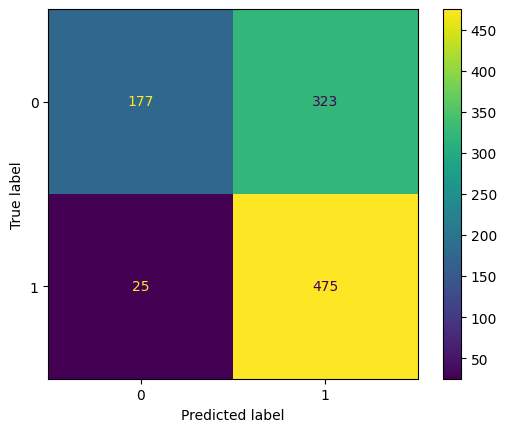

F1 score for positive class: 0.7319
F1 score for negative class: 0.5043


In [8]:
y_true = yelp_data['Sentiment'].values

disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()
plt.show()

print(f'F1 score for positive class: {f1_score(y_true, y_pred, pos_label=1):.4}')
print(f'F1 score for negative class: {f1_score(y_true, y_pred, pos_label=0):.4}')


In [9]:
print(classification_report(y_true, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.88      0.35      0.50       500
    positive       0.60      0.95      0.73       500

    accuracy                           0.65      1000
   macro avg       0.74      0.65      0.62      1000
weighted avg       0.74      0.65      0.62      1000



In [11]:
### Test

model1.predict_sentiment('Not good')[0]

0

### Using $\lambda$ parameter (*Implicit learning from test Yelp data)

Decision rule:

\begin{equation}
    Sentiment = 
    \begin{cases} 
    1, \quad \text{if } \frac{f^+}{f^-} > \lambda \\
    0, \quad \text{otherwise.}
    \end{cases}    
    \end{equation} 


In [12]:
# we've run this calculation above
# y_pred_raw = np.array(yelp_data['Review'].progress_apply(model1.predict_sentiment))
pos_scores = [i[1] for i in y_pred_raw]
neg_scores = [i[2] for i in y_pred_raw]


In [13]:
lambd_range = np.linspace(1, 5, 100)

f1_pos = []
f1_neg = []

for lambd in lambd_range:
    y_pred = []
    for pos_senti_score, neg_senti_score in zip(pos_scores, neg_scores):
        y_pred.append(1 if pos_senti_score/max(abs(neg_senti_score), 1e-6) > lambd else 0)
    y_pred = np.array(y_pred)
    
    f1_pos.append(f1_score(y_true, y_pred, pos_label=1))
    f1_neg.append(f1_score(y_true, y_pred, pos_label=0))


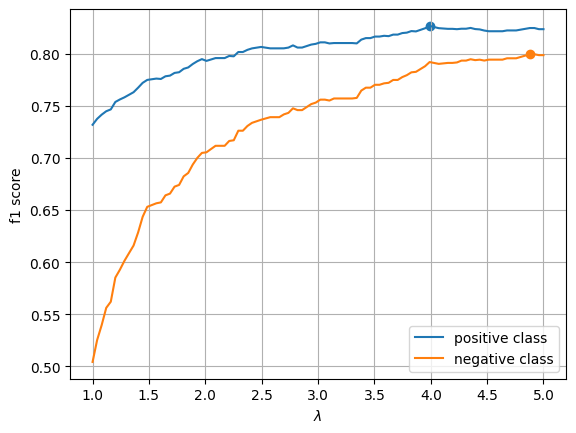

Best lambda and f1 for positive class: 4.0, 0.83


In [14]:
plt.plot(lambd_range, f1_pos, label='positive class')
plt.plot(lambd_range, f1_neg, label='negative class')

plt.scatter(lambd_range[np.argmax(f1_pos)], np.max(f1_pos))
plt.scatter(lambd_range[np.argmax(f1_neg)], np.max(f1_neg))

plt.xlabel('$\lambda$')
plt.ylabel('f1 score')

plt.legend()
plt.grid()
plt.show()

print(f'Best lambda and f1 for positive class: {lambd_range[np.argmax(f1_pos)]:.2}, {np.max(f1_pos):.2}')
#print(f'Best lambda and f1 for negative class: {lambd_range[np.argmax(f1_neg)]:.2}, {np.max(f1_neg):.2}')


The obtained $\lambda$ value yields the best f1-score for the positive class. But, the f1-score for the negative class continues to grow as we increase $\lambda$ over the much wider range ($\lambda > 5$). However, as this increase is unsignificant, we will choose the best option for f1 score for the positive class.

In [15]:
# Recalculating metrics for the chosen lambda parameter

y_pred_raw = np.array(yelp_data['Review'].progress_apply(model1.predict_sentiment, args=(4,)))
y_pred = [i[0] for i in y_pred_raw]


100%|███████████████████████████████████████| 1000/1000 [01:21<00:00, 12.22it/s]


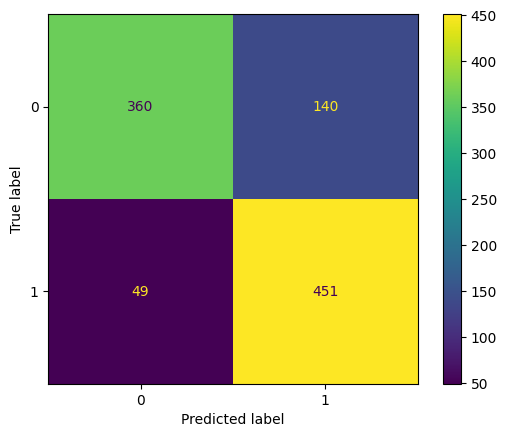

F1 score for positive class: 0.8268
F1 score for negative class: 0.7921


In [16]:
y_true = yelp_data['Sentiment'].values

disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()
plt.show()

print(f'F1 score for positive class: {f1_score(y_true, y_pred, pos_label=1):.4}')
print(f'F1 score for negative class: {f1_score(y_true, y_pred, pos_label=0):.4}')


In [17]:
print(classification_report(y_true, y_pred, target_names=['negative', 'positive']))


              precision    recall  f1-score   support

    negative       0.88      0.72      0.79       500
    positive       0.76      0.90      0.83       500

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000



## 5. Stanza Sentiment Analysis Model

In [18]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', download_method=None, tokenize_no_ssplit=True)

2023-09-21 19:19:14 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2023-09-21 19:19:14 INFO: Using device: cpu
2023-09-21 19:19:14 INFO: Loading: tokenize
2023-09-21 19:19:14 INFO: Loading: sentiment
2023-09-21 19:19:14 INFO: Done loading processors!


In [19]:
y_pred_stanza = []

for i, row in tqdm(yelp_data.iterrows(), total=len(yelp_data)):
    doc = nlp(row['Review'])
    
    sentence = doc.sentences[0]
    if sentence.sentiment in [2]: # (there 38 predicted neutral sentences, we will classify them as positive)
        y_pred_stanza.append(1)
    elif sentence.sentiment in [0,1]:
        y_pred_stanza.append(0)
    
y_pred_stanze = np.array(y_pred_stanza)
    

100%|███████████████████████████████████████| 1000/1000 [01:17<00:00, 12.97it/s]


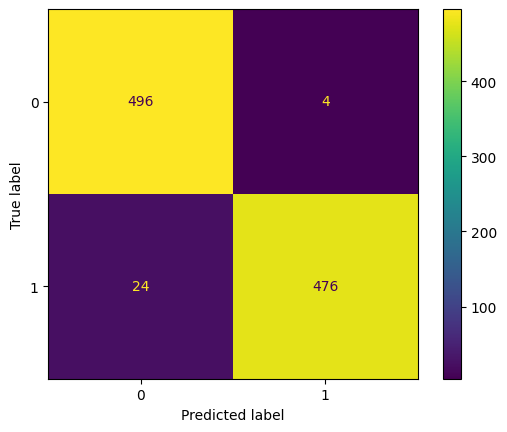

F1 score for positive class: 0.9714
F1 score for negative class: 0.9725


In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_stanza))
disp.plot()
plt.show()

print(f'F1 score for positive class: {f1_score(y_true, y_pred_stanza, pos_label=1):.4}')
print(f'F1 score for negative class: {f1_score(y_true, y_pred_stanza, pos_label=0):.4}')


In [21]:
print(classification_report(y_true, y_pred_stanza, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.95      0.99      0.97       500
    positive       0.99      0.95      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

